In [1]:
#import dependencies
from __future__ import division
import pandas as pd
import numpy as np
import os
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

from PIL import Image
from tqdm import tqdm

In [6]:
#let us count the number of train images and test images
no_of_train = len(os.listdir(str(os.getcwd())+'/train/train/'))
print("No. of training examples: " + str(no_of_train))

no_of_test = len(os.listdir(str(os.getcwd())+'/test/test/'))
print("No. of test examples: " + str(no_of_test))

No. of training examples: 10222
No. of test examples: 10357


In [2]:
#Also let us check the different types of dog breeds present in data
labels = pd.read_csv('labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
print(labels['breed'].unique())
print("\nTotal breeds available: "+ str(len(labels['breed'].unique())))

['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'borzoi' 'basenji' 'scottish_deerhound'
 'shetland_sheepdog' 'walker_hound' 'maltese_dog' 'norfolk_terrier'
 'african_hunting_dog' 'wire-haired_fox_terrier' 'redbone'
 'lakeland_terrier' 'boxer' 'doberman' 'otterhound' 'standard_schnauzer'
 'irish_water_spaniel' 'black-and-tan_coonhound' 'cairn' 'affenpinscher'
 'labrador_retriever' 'ibizan_hound' 'english_setter' 'weimaraner'
 'giant_schnauzer' 'groenendael' 'dhole' 'toy_poodle' 'border_terrier'
 'tibetan_terrier' 'norwegian_elkhound' 'shih-tzu' 'irish_terrier' 'kuvasz'
 'german_shepherd' 'greater_swiss_mountain_dog' 'basset'
 'australian_terrier' 'schipperke' 'rhodesian_ridgeback' 'irish_setter'
 'appenzeller' 'bloodhound' 'samoyed' 'miniature_schnauzer'
 'brittany_spaniel' 'kelpie' 'papillon' 'border_collie' 'entlebucher'
 'collie' 'malamute' 'welsh_springer_spaniel' 'chihuahua' 'saluki' 'pug'
 'malinois' 'komondor' 'airedale' 'leonberg' 'mexican_h

### Since this is a computer vision problem. SVM's and deep learning is the best approach. We will use deep learning in this notebook.

In [ ]:
path_to_image = os.getcwd() + '/train/train/' + os.listdir(str(os.getcwd())+'/train/train/')[0]

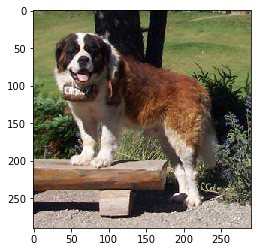


shape of image: 290x290x3


In [23]:
#let us check the dimension of one image and also visualize it

path_to_image = os.getcwd() + '/train/train/' + os.listdir(str(os.getcwd())+'/train/train/')[0]



pil_image = Image.open(path_to_image, 'r')
plt.imshow(pil_image)
plt.show()

print('\nshape of image: ' + str(np.asarray(pil_image).shape[0]) + 'x' + str(np.asarray(pil_image).shape[1]) + 'x' + str(np.asarray(pil_image).shape[2]))

In [54]:
#let us now separate the training set into 120 folders so that it is easy to train
import shutil



image_list = os.listdir(str(os.getcwd())+'/train/train/')

for i in labels['breed'].unique():
    os.mkdir(os.getcwd()+'/train/train/' + str(i))

for i in tqdm(image_list):
    
    current_dir = os.getcwd()+'/train/train/' + str(i)
    destination_dir = os.getcwd()+'/train/train/' + str(labels[labels['id']==i[:-4]]['breed'].values[0] + '/'+str(i))
    
    shutil.move(current_dir, destination_dir)

100%|██████████| 10222/10222 [00:16<00:00, 614.91it/s]


In [57]:
#let us take 10 images from each breed as validation set

os.mkdir(os.getcwd()+'/train/validation')

breed_list = os.listdir(os.getcwd()+'/train/train/')

for i in breed_list:
    os.mkdir(os.getcwd()+'/train/validation/' + i)

for i in tqdm(breed_list):
    train_list = os.listdir(os.getcwd()+'/train/train/' + i + '/')
    for ii in train_list[:10]:
        shutil.move(os.getcwd()+'/train/train/' + i + '/' + ii, os.getcwd()+'/train/validation/' + i + '/' + ii)

100%|██████████| 120/120 [00:00<00:00, 3188.35it/s]


For a statistical model we could have used SVM, but considering the amount of data and the amount of labels. classifying using SVM will take a very long time.

we will use transfer learning to train our deep learning model. We will use the InceptionV3 model with pretrained weights to train the model. We need to use a fully connected layer with 120 node output so that it can predict the probability of each breed

In [5]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K


batch_size=150


train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train/train',  # this is the target directory
        target_size=(290, 290),  # all images will be resized to 256x256
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        'train/validation',
        target_size=(290, 290),
        batch_size=batch_size,
        class_mode='categorical')

model = applications.InceptionV3(weights = "imagenet", include_top=False, input_shape = (290, 290, 3))

for layer in model.layers:
    layer.trainable = False


x = model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(120, activation="softmax")(x)



# creating the final model 
model_final = Model(inputs = model.inputs, outputs = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

checkpoint = ModelCheckpoint("inception_weights_trained.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=10, verbose=1, mode='auto')

model_final.summary()

Found 9022 images belonging to 120 classes.
Found 1200 images belonging to 120 classes.
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 290, 290, 3)   0                                            
____________________________________________________________________________________________________
conv2d_95 (Conv2D)               (None, 144, 144, 32)  864         input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_95 (BatchNor (None, 144, 144, 32)  96          conv2d_95[0][0]                  
____________________________________________________________________________________________________
activation_95 (Activation)       (None, 144, 144, 32)  0           batch_normalization_95[0][0]     
___

In [7]:
K.clear_session()

In [ ]:
model_final.fit_generator(
train_generator,
steps_per_epoch = 9022//batch_size,
epochs = 100,
validation_data = validation_generator,
validation_steps = 1200//batch_size,
callbacks = [checkpoint, early])

Epoch 1/100
60/60 [==============================] - 250s - loss: 7.5048 - acc: 0.0486 - val_loss: 3.6374 - val_acc: 0.2108
Epoch 2/100
60/60 [==============================] - 242s - loss: 4.2415 - acc: 0.1007 - val_loss: 2.7968 - val_acc: 0.2933
Epoch 3/100
60/60 [==============================] - 257s - loss: 4.0054 - acc: 0.1222 - val_loss: 2.5843 - val_acc: 0.3467
Epoch 4/100
60/60 [==============================] - 255s - loss: 3.8759 - acc: 0.1361 - val_loss: 2.3385 - val_acc: 0.3750
Epoch 5/100
60/60 [==============================] - 265s - loss: 3.8062 - acc: 0.1439 - val_loss: 2.3809 - val_acc: 0.3800
Epoch 6/100
60/60 [==============================] - 366s - loss: 3.7490 - acc: 0.1512 - val_loss: 2.0735 - val_acc: 0.4683
Epoch 7/100
60/60 [==============================] - 315s - loss: 3.6891 - acc: 0.1622 - val_loss: 2.0869 - val_acc: 0.4275
Epoch 8/100
60/60 [==============================] - 298s - loss: 3.5677 - acc: 0.1847 - val_loss: 2.0074 - val_acc: 0.4717
Epoch 9/

Training for even more time and training with a bigger fully connected layer would yeid better results.
Here the model results in a validation accuracy of 81.9%. Let us predic on the test set and check the score on the leaderboard

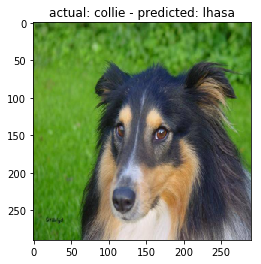

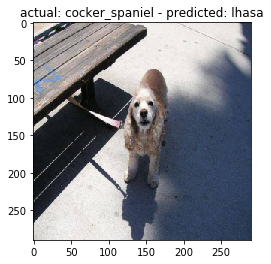

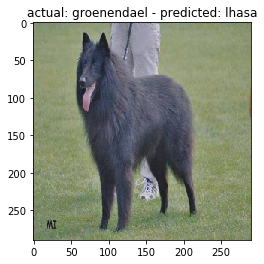

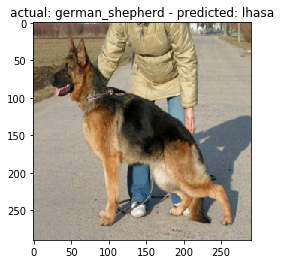

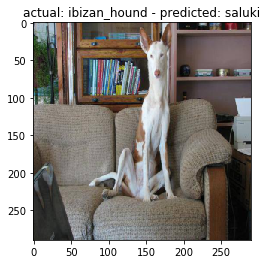

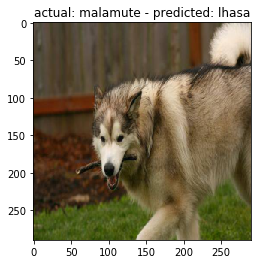

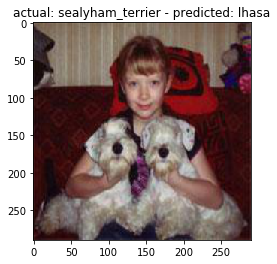

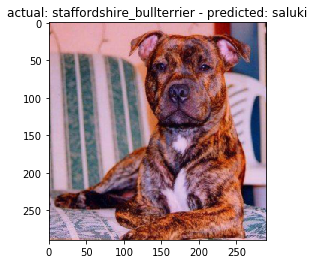

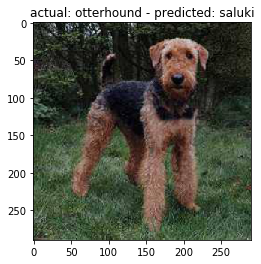

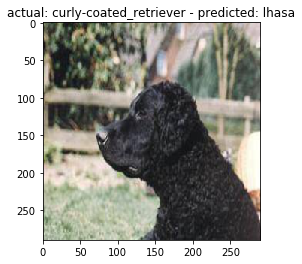

In [6]:
#let us check our predictions on the train_set first

from scipy import ndimage, misc

labels_1 = os.listdir(os.getcwd()+'/train/validation/')

model_final.load_weights('inception_weights_trained.h5')


for i in os.listdir(os.getcwd()+'/train/validation/')[:10]:
    for ii in os.listdir(os.getcwd()+'/train/validation/'+ i)[:1]:
        
        path_to_image = os.getcwd() + '/train/validation/' + i + '/' + ii
        pil_image = Image.open(path_to_image, 'r')
        
        pil_image = misc.imresize(pil_image, (290,290))
        
        plt.imshow(pil_image)
        
        pil_image = np.reshape(np.asarray(pil_image), (1,290,290,3))
        
        prediction = model_final.predict(pil_image)
        
        prediction = int(np.argmax(prediction))
        
        #print(prediction)
        
        predicted_label = labels_1[prediction]
        
        plt.title("actual: %s - predicted: %s" %(i,predicted_label))
        
        plt.show()

In [ ]:
#Not a good predictor. so many mistakes